In [1]:
import os
import utils
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.cache_handler import CacheFileHandler
from dotenv import load_dotenv
load_dotenv()

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=os.environ['SPOTIFY_CLIENT_ID'], client_secret=os.environ['SPOTIFY_CLIENT_SECRET'], cache_handler=CacheFileHandler(username='keatonconrad')))

In [13]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from models.song_data import Song, Artist, Base

engine = create_engine('sqlite:///testdb.db')
Base.metadata.create_all(bind=engine)

Session = sessionmaker(bind=engine)
session = Session()

# Importing Data

## Million Song Dataset

To start, we import a subset of the [Million Song Dataset](http://millionsongdataset.com/) and read it into a DataFrame with pandas for easy processing. The dataset contains random songs of various genres from 1922 to 2011. We'll use this to collect non-hit songs.

The DataFrame is shuffled to mitigate any bias in the order.

In [14]:
song_data = pd.read_csv('./song-list.txt', sep='<SEP>', engine='python')
song_data = song_data.sample(frac=1)
song_data.describe()

,Year
count,515576.000000
mean,1998.397233
std,10.930534
min,1922.000000
25%,1994.000000
50%,2002.000000
75%,2006.000000
max,2011.000000


## Spotify and Billboard Data

We import a dataset that contains historical Billboard Hot 100 data mapped to each song's Spotify ID. This is incredibly useful as it helps us collect the audio features later. This dataset will be used to collect features from hit songs.

Like the previous dataset, we shuffle it to avoid any ordering bias.

In [15]:
spotify_billboard_data = pd.read_csv('./spotify-billboard-data.csv')
spotify_billboard_data = spotify_billboard_data.sample(frac=1)
print(spotify_billboard_data.columns)
hit_track_ids = spotify_billboard_data['spotify_track_id'].tolist()
spotify_billboard_data.describe()

Index(['spotify_track_id', 'songid', 'performer', 'song',
       'spotify_track_album', 'spotify_track_explicit',
       'first_chart_appearance', 'peak_position', 'weeks_on_chart'],
      dtype='object')


,peak_position,weeks_on_chart
count,23521.000000,23521.000000
mean,81.205774,11.803877
std,17.969314,8.309004
min,1.000000,1.000000
25%,75.000000,5.000000
50%,86.000000,11.000000
75%,94.000000,17.000000
max,100.000000,87.000000


# Data Enrichment

## Non-Hit Songs

We can't do much with just the song title and artist, as given in the Million Song Dataset. Here, we do a search on Spotify to find the closest matching song and retrieve the track ID, album, and explicit information, among other data.

It should be noted that this step has some inherent inaccuracy due to its reliance on Spotify's search feature. There is no guarantee the correct song will be returned.

In [16]:
from tqdm import tqdm

no_hit_arr = []
song_data_sample = song_data.head(len(spotify_billboard_data) * 5)

for i, song in tqdm(song_data_sample.iterrows(), total=song_data_sample.shape[0]):
    artist = song['Performer'].replace('Featuring ', '').replace('feat. ', '').replace('feat ', '').replace('& ', '')
    search_results = spotify.search(q=song['Song'] + ' ' + artist, limit=1, type='track', market='US')
    try:
        track = search_results['tracks']['items'][0]
    except IndexError:
        # If search didn't return anything
        continue
        
    if track['id'] not in hit_track_ids:
        utils.save_track_info(track, session, hit=False)

  0%|          | 17/117605 [00:05<10:39:48,  3.06it/s]


KeyboardInterrupt: 

## Hit Songs

While the Spotify and Billboard dataset provides more data than the Million Song Dataset we are using, we still collect more information from Spotify about the album and release year.

This step isn't necessarily required, as the album name isn't used for much. However, it is quick due to already having the track IDs.

In [79]:
track_ids = []

for i, song in tqdm(spotify_billboard_data.iterrows(), total=spotify_billboard_data.shape[0]):
    track_ids.append(song['spotify_track_id'])
    
    if len(track_ids) == 50 or i == spotify_billboard_data.shape[0] - 1:
        results = spotify.tracks(tracks=track_ids)['tracks']
        for track in results:            
            utils.save_track_info(track, session, hit=True)
            
        track_ids.clear()

  3%|▎         | 599/23521 [00:05<03:15, 117.42it/s]


KeyboardInterrupt: 

## Feature Collection

We collect the audio features for each track using the Spotify API and the track IDs from the newly created DataFrame.

Due to how the code makes API calls in batches of 100, it will ignore the last few tracks.

In [18]:
track_ids = []

all_basic_song_data = session.query(Song).all()

for song_data in tqdm(all_basic_song_data):
    if song_data.danceability is not None:
        # If song already has audio features
        continue

    track_ids.append(song_data.spotify_id)

    if len(track_ids) == 100:
        results = spotify.audio_features(tracks=track_ids)
        for result in results:
            if not result:
                continue

            existing_song = next((song for song in all_basic_song_data if song.spotify_id == result['id']), None)
            result.pop('id', None)
            existing_song.update(result)
            session.commit()

        track_ids.clear()

PendingRollbackError: This Session's transaction has been rolled back due to a previous exception during flush. To begin a new transaction with this Session, first issue Session.rollback(). Original exception was:  (Background on this error at: https://sqlalche.me/e/14/7s2a)

In [19]:
from scipy.stats import ttest_ind

"""
for column in full_df.columns:
    try:
        t = ttest_ind(hit_df[column].astype(float), no_hit_df[column].astype(float))
        print(column + ' - T: ' + str(t[0]) + ', p: ' + str(t[1]))
    except ValueError:
        continue
"""

"\nfor column in full_df.columns:\n    try:\n        t = ttest_ind(hit_df[column].astype(float), no_hit_df[column].astype(float))\n        print(column + ' - T: ' + str(t[0]) + ', p: ' + str(t[1]))\n    except ValueError:\n        continue\n"

## Lyric Collection

Using the Genius API, we collect the lyrics of every song in our dataset. The polarity and subjectivity of the lyrics are also saved to an array.

Similar to above, this step has inherent inaccuracies due to its reliance on Genius's search feature.

The polariy, subjectivity, and lyrics are pickled and saved for easy loading later.

In [8]:
import lyricsgenius
genius = lyricsgenius.Genius(os.environ['GENIUS_TOKEN'], verbose=False, remove_section_headers=False)

In [82]:
from tqdm import tqdm
from textblob import TextBlob
from random import shuffle

all_data_rows = session.query(Song, Artist).all()
shuffle(all_data_rows)

for song, artist in tqdm(all_data_rows):
    try:
        if song.lyrics is not None:
            # If the song already has lyrics
            continue
        
        result = genius.search_song(song.title, ' ' + artist.name, get_full_info=False)
        song.lyrics = result.lyrics
        song.lyric_length = len(result.lyrics)
        
        blob = TextBlob(result.lyrics)
        song.polarity = blob.sentiment[0]
        song.subjectivity = blob.sentiment[1]
        session.commit()
    except Exception as e:
        continue


InvalidRequestError: This session is in 'committed' state; no further SQL can be emitted within this transaction.

## Artist Popularity

This gets the popularity of every artist

In [77]:
artist_ids = []
session.rollback()

all_artist_data = session.query(Artist).filter(Artist.popularity == None).all()

for i, artist_data in tqdm(enumerate(all_artist_data), total=len(all_artist_data)):
    artist_ids.append(artist_data.spotify_id)

    if len(artist_ids) == 50 or i == len(all_artist_data) - 1:
        results = spotify.artists(artist_ids)
        for result in results['artists']:
            existing_artist = next((artist for artist in all_artist_data if artist.spotify_id == result['id']), None)
            try:
                existing_artist.popularity = result['popularity']
                existing_artist.followers = result['followers']['total']
                try:
                    existing_artist.primary_genre = result['genres'][0]
                except:
                    pass
                session.commit()
            except:
                continue

        artist_ids.clear()

0it [00:00, ?it/s]


## Previous Artist Hits

This gets an artist's previous hits. It adds up all the artist's hit songs in the dataset that are in the same year or previous years, not counting that song, if it's a hit.

In [78]:
num_hits = []

all_song_data = session.query(Song).filter(Song.num_artist_hits_at_release == None).all()

for song in tqdm(all_song_data, total=len(all_song_data)):
    song.num_artist_hits_at_release = (
        session.query(Song.id)
        .filter_by(artist_id=song.artist_id, hit=True)
        .filter(Song.year <= song.year)
        .filter(Song.id != song.id)
        .count()
    )
    session.commit()

0it [00:00, ?it/s]


In [113]:
import pandas as pd

df = pd.read_sql('SELECT * FROM song JOIN artist ON song.artist_id = artist.id', engine)

In [102]:
# This drops rows without every value (drops rows that don't have lyrics)
# This is necessary for doing embeddings

df.dropna(subset=[n for n in df if n != 'isrc'], inplace=True)

In [105]:
df['lyric_length'] = df['lyric_length'].fillna(0)
df['lyrics'] = df['lyrics'].fillna('')
df.dropna(subset=['danceability'], inplace=True) # Drops all rows that don't have basic features for whatever reason

In [93]:
df = df[(df.year.astype(int) < 2011) & (df.year.astype(int) > 1957)]

We now have our completed dataset.

In [110]:
df.describe()

,id,artist_id,current_popularity,year,explicit,hit,polarity,subjectivity,lyric_length,num_artist_hits_at_release,id,followers,popularity
count,287043.000000,287043.000000,287043.000000,287043.000000,287043.000000,287043.000000,12714.000000,12714.000000,12714.000000,153546.000000,287043.000000,1.643600e+05,164360.000000
mean,294.000000,230.187394,35.408859,1995.700170,0.095400,0.971039,0.084803,0.478323,23349.038462,0.156051,245.000000,2.836500e+06,55.289286
std,169.452353,140.099439,22.089907,16.066713,0.293768,0.167697,0.118581,0.110405,28896.416188,0.476699,141.162092,8.118072e+06,20.602903
min,1.000000,1.000000,0.000000,1959.000000,0.000000,0.000000,-0.201761,0.107143,714.000000,0.000000,1.000000,4.600000e+01,1.000000
25%,147.000000,107.000000,17.000000,1982.000000,0.000000,1.000000,0.049851,0.449092,2852.000000,0.000000,123.000000,4.643200e+04,44.000000
50%,294.000000,220.000000,36.000000,1998.000000,0.000000,1.000000,0.092410,0.486434,9510.000000,0.000000,245.000000,3.841610e+05,59.000000
75%,441.000000,348.000000,53.000000,2009.000000,0.000000,1.000000,0.135762,0.518420,34011.000000,0.000000,367.000000,1.449431e+06,69.000000
max,587.000000,489.000000,83.000000,2019.000000,1.000000,1.000000,0.418243,0.791667,95749.000000,3.000000,489.000000,6.947760e+07,100.000000


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


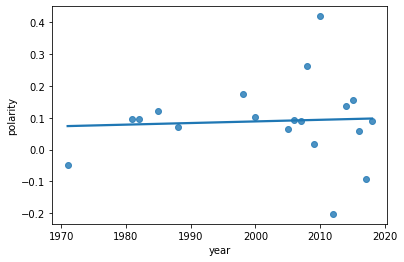

In [114]:
#%pip install seaborn
import seaborn as sns

data_df = df.groupby(['year']).mean().reset_index()
data_df = data_df[data_df['year'].astype(int) > 1960]
sns_plot = sns.regplot(data_df['year'].astype(int), data_df['polarity'], order=1, ci=None)
# sns_plot.figure.savefig('polarity.pdf')

# Data Preparation

We extract our target variable (hit or not) from the dataset. Then, we drop irrelevant and non-numerical columns from the dataset to form our x inputs.

The dataset is then split into training and validation sets. The new datasets are not shuffled to ensure that the lyrics correspond to the correct auxiliary variables.

In [ ]:
import sklearn as sk
from sklearn.model_selection import train_test_split

y_data = df['hit']
x_data = df.drop(['hit', 'artist', 'artist_id', 'isrc', 'lyrics', 'song', 'id', 'spotify_track_id', 'spotify_track_album', 'analysis_url', 'uri', 'track_href', 'type', 'current_popularity'], axis=1, inplace=False)
print(x_data.columns)
x_data_train, x_data_test, y_data_train, y_data_test = train_test_split(
    x_data, y_data, test_size=0.2, shuffle=False
)

lyrics_train, lyrics_eval = train_test_split(df['lyrics'], test_size=0.2, shuffle=False)
print(len(y_data_train))
print(len(lyrics_train))
print(len(x_data_train))
print(y_data_train.describe())

Index(['year', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature',
       'artist_popularity', 'artist_num_hits', 'polarity', 'subjectivity',
       'lyric_length'],
      dtype='object')
22480
22480
22480
count    22480.000000
mean         0.561432
std          0.496223
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: hit, dtype: float64


In [ ]:
polarity_mean = x_data_train['polarity'].mean()
subjectivity_mean = x_data_train['subjectivity'].mean()

pd.options.mode.chained_assignment = None  # default='warn'

x_data_train['polarity'] = x_data_train['polarity'].fillna(polarity_mean)
x_data_test['polarity'] = x_data_test['polarity'].fillna(polarity_mean)
x_data_train['subjectivity'] = x_data_train['subjectivity'].fillna(subjectivity_mean)
x_data_test['subjectivity'] = x_data_test['subjectivity'].fillna(subjectivity_mean)

We then scale our auxiliary input variables using the StandardScaler.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_model = StandardScaler()

x_data_train = pd.DataFrame(
    scaler_model.fit_transform(x_data_train),
    columns=x_data_train.columns,
    index=x_data_train.index
)
x_data_test = pd.DataFrame(
    scaler_model.transform(x_data_test),
    columns=x_data_test.columns,
    index=x_data_test.index
)

# Simple Classification Models

The below code blocks show the results of the classification task using the auxiliary variables alone as inputs into various classifier models.

In [ ]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0).fit(x_data_train, y_data_train)
print(round(LR.score(x_data_test, y_data_test), 4))
lr_preds = LR.predict(x_data_test)
print(sk.metrics.precision_recall_fscore_support(y_data_test, lr_preds, average='binary'))
print(sk.metrics.confusion_matrix(y_data_test, lr_preds))

NameError: ignored

In [ ]:
SVM = sk.svm.SVC()
SVM.fit(x_data_train, y_data_train)
print(round(SVM.score(x_data_test, y_data_test), 4))
svm_preds = SVM.predict(x_data_test)
print(sk.metrics.precision_recall_fscore_support(y_data_test, svm_preds, average='binary'))
print(sk.metrics.confusion_matrix(y_data_test, svm_preds))

0.8176
(0.8353361481000324, 0.8323624595469256, 0.8338466526179283, None)
[[2023  507]
 [ 518 2572]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=500, max_depth=100, random_state=0)
RF.fit(x_data_train, y_data_train)
print(round(RF.score(x_data_test, y_data_test), 4))
rf_preds = RF.predict(x_data_test)
print(sk.metrics.precision_recall_fscore_support(y_data_test, rf_preds, average='binary'))
print(sk.metrics.confusion_matrix(y_data_test, rf_preds))

0.8491
(0.8466295609152752, 0.886084142394822, 0.8659076533839343, None)
[[2034  496]
 [ 352 2738]]


In [ ]:
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier(solver='adam', alpha=0.01, hidden_layer_sizes=(30, 10, 10), random_state=1, activation='relu')
NN.fit(x_data_train, y_data_train)
print(round(NN.score(x_data_test, y_data_test), 4))
nn_preds = NN.predict(x_data_test)
print(sk.metrics.precision_recall_fscore_support(y_data_test, nn_preds, average='binary'))
print(sk.metrics.confusion_matrix(y_data_test, nn_preds))

0.8444
(0.8385372714486639, 0.8593254540213318, 0.8488041002277904, None)
[[2783  574]
 [ 488 2981]]


In [ ]:
from sklearn.naive_bayes import BernoulliNB

NB = BernoulliNB()
NB.fit(x_data_train, y_data_train)
print(round(NB.score(x_data_test, y_data_test), 4))
nb_preds = NB.predict(x_data_test)
print(sk.metrics.precision_recall_fscore_support(y_data_test, nb_preds, average='binary'))
print(sk.metrics.confusion_matrix(y_data_test, nb_preds))

0.7762
(0.8061497326203209, 0.7805825242718447, 0.7931601446892469, None)
[[1950  580]
 [ 678 2412]]


In [ ]:
from tqdm import tqdm
import nltk
nltk.download('stopwords')
import utils
import string

lyrics_train_cleaned = pd.Series([utils.strip_stop_words(utils.remove_contractions(l)).translate(str.maketrans('', '', string.punctuation)) for l in tqdm(lyrics_train)])
lyrics_eval_cleaned = pd.Series([utils.strip_stop_words(utils.remove_contractions(l)).translate(str.maketrans('', '', string.punctuation)) for l in tqdm(lyrics_eval)])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


100%|██████████| 5620/5620 [01:07<00:00, 83.11it/s] 


In [ ]:
from tensorflow.keras.layers import TextVectorization

count = lyrics_train_cleaned.str.count(' ').add(1)
print(count.describe())

maxlen = 256
vocab_size = 1000

seqs_train_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=maxlen
)
seqs_train_vectorization.adapt(lyrics_train_cleaned)
seqs_train = seqs_train_vectorization(lyrics_train_cleaned)

seqs_eval_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=maxlen
)
seqs_eval_vectorization.adapt(lyrics_eval_cleaned)
seqs_eval = seqs_eval_vectorization(lyrics_eval_cleaned)

count    22480.000000
mean      2305.106317
std       8355.731283
min          1.000000
25%         93.000000
50%        142.000000
75%        309.000000
max      85837.000000
dtype: float64


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input, GlobalAveragePooling1D, concatenate
from tensorflow.keras.models import Model
from custom_layers import TransformerBlock, TokenAndPositionEmbedding

In [ ]:
print('Building model...')

with strategy.scope():

  lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.00)

  # Branch 1
  aux_input = Input(shape=(len(x_data_train.columns),))
  aux = Dense(400, activation=lrelu)(aux_input)
  aux = BatchNormalization()(aux)
  aux = Model(inputs=aux_input, outputs=aux)

  # Branch 2
  embed_dim = 256  # Embedding size for each token
  num_heads = 2  # Number of attention heads
  ff_dim = 128  # Hidden layer size in feed forward network inside transformer

  emb_input = Input(shape=(maxlen,))
  x = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(emb_input)
  x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
  x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
  x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
  x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
  x = GlobalAveragePooling1D()(x)
  x = Dropout(0.1)(x)
  emb = Model(inputs=emb_input, outputs=x)

  # Combined
  combined = concatenate([aux.output, emb.output])
  z = Dense(64, activation=lrelu)(combined)
  z = BatchNormalization()(z)
  z = Dropout(.2)(z)
  z = Dense(64, activation=lrelu)(z)
  z = Dense(1, activation='sigmoid')(z)

  model = Model(inputs=[aux.input, emb.input], outputs=z)

  optimizer = keras.optimizers.SGD(0.01)

  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

es = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001, verbose=1)

print(x_data_train.shape)
print(seqs_train.shape)
# print(model.summary())

Building model...
(22480, 20)
(22480, 256)


In [ ]:
history = model.fit(
    [x_data_train, seqs_train],
    y_data_train,
    validation_data=([x_data_test, seqs_eval], y_data_test),
    batch_size=32,
    epochs=200,
    shuffle=True,
    verbose=1,
    callbacks=[es, rlr]
)

Epoch 1/200
703/703 [==============================] - 62s 54ms/step - loss: 0.5500 - acc: 0.7200 - precision_26: 0.7447 - recall_26: 0.7626 - val_loss: 0.4809 - val_acc: 0.7639 - val_precision_26: 0.8727 - val_recall_26: 0.6680
Epoch 2/200
703/703 [==============================] - 17s 25ms/step - loss: 0.5136 - acc: 0.7531 - precision_26: 0.7782 - recall_26: 0.7835 - val_loss: 0.4868 - val_acc: 0.7897 - val_precision_26: 0.7495 - val_recall_26: 0.9275
Epoch 3/200
703/703 [==============================] - 18s 25ms/step - loss: 0.4946 - acc: 0.7668 - precision_26: 0.7892 - recall_26: 0.7978 - val_loss: 0.4274 - val_acc: 0.8162 - val_precision_26: 0.8521 - val_recall_26: 0.8055
Epoch 4/200
703/703 [==============================] - 18s 25ms/step - loss: 0.4825 - acc: 0.7738 - precision_26: 0.7916 - recall_26: 0.8106 - val_loss: 0.4259 - val_acc: 0.8219 - val_precision_26: 0.8428 - val_recall_26: 0.8311
Epoch 5/200
703/703 [==============================] - 18s 25ms/step - loss: 0.4732 

KeyboardInterrupt: ignored

In [ ]:
pred_train = model.evaluate([x_data_train, seqs_train], y_data_train)
pred_test = model.evaluate([x_data_test, seqs_eval], y_data_test)
y_pred_train = model.predict([x_data_train, seqs_train]).astype('int').flatten()
y_pred = model.predict([x_data_test, seqs_eval]).astype('int').flatten()

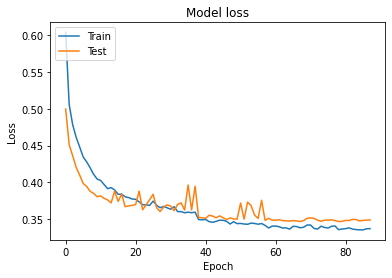

In [ ]:
#%pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

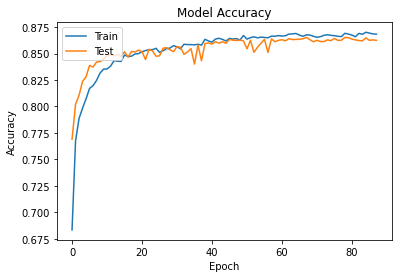

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# %pip install seaborn
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib import pyplot as plt

df_corr = pd.DataFrame() # Correlation matrix
df_p = pd.DataFrame()  # Matrix of p-values
for x in x_data.columns:
    # for y in full_df.columns:
    corr = pearsonr(x_data[x].astype(float), y_data)
    df_corr.loc[x,0] = corr[0]
    df_p.loc[x,0] = corr[1]


# mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
cmap = sns.diverging_palette(240, 10, as_cmap=True)

f = plt.figure(figsize=(8, 7))
# plt.rc('xtick', labelsize=10)
# plt.rc('ytick', labelsize=10)
ax = sns.heatmap(df_corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .6})
ax.set_title('Pearson Correlation Matrix')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.tight_layout()
plt.show()

f = plt.figure(figsize=(8, 7))
# plt.rc('xtick', labelsize=10)
# plt.rc('ytick', labelsize=10)
ax = sns.heatmap(df_p, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .6})
ax.set_title('P-Value Matrix from Pearson Correlation')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.tight_layout()
plt.show()